In [8]:
import pandas as pd

testing_df = pd.read_csv('data/testing/testing_dataset.csv')
testing_df.columns

Index(['text', 'Sentiment_Text'], dtype='object')

In [9]:
import torch
from transformers import XLMRobertaTokenizer
from preprocessing import Preprocessing
from model_3 import SemanticClassifier

labels = ["Negative", "Neutral", "Positive"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preprocessing_instance = Preprocessing()

state_dict = torch.load(
    "data/semantic_classifier_3_2_dict.pth", map_location=device
)
model = SemanticClassifier()
model.load_state_dict(state_dict)
model.to(device)
model.eval()

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")


def preprocess_text(text, max_length=128, device="cuda"):
    processed_text = preprocessing_instance.preprocessing_pipeline_roberta(text)
    processed_text = str(processed_text)
    encoding = tokenizer(
        processed_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

    return {
        "input_ids": encoding["input_ids"].to(device),
        "attention_mask": encoding["attention_mask"].to(device),
    }


def predict(text):
    inputs = preprocess_text(text, device=device)

    with torch.no_grad():
        output = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])

    predicted_label = torch.argmax(output, dim=1).cpu().item()
    return labels[int(predicted_label)]

testing_df["Predicted_Sentiment_Text"] = testing_df["text"].apply(predict)

In [10]:
label_dict = {
    0:'Negative',
    1:'Neutral',
    2:'Positive'
}

testing_df['Sentiment_Text'] = testing_df['Sentiment_Text'].apply(lambda x: label_dict[x])

In [11]:
testing_df.head()

,text,Sentiment_Text,Predicted_Sentiment_Text
0,"Walao, this shop damn expensive lah!",Negative,Neutral
1,"Bro, jom go makan nasi lemak at that place!",Neutral,Neutral
2,"Aiyo, why you so blur one?",Negative,Neutral
3,"This movie damn syok, must watch!",Positive,Positive
4,Can borrow me your charger ah?,Neutral,Neutral


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = testing_df['Sentiment_Text']
y_pred = testing_df['Predicted_Sentiment_Text']

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[ 6 18  0]
 [ 0 16  1]
 [ 4  0 24]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.60      0.25      0.35        24
     Neutral       0.47      0.94      0.63        17
    Positive       0.96      0.86      0.91        28

    accuracy                           0.67        69
   macro avg       0.68      0.68      0.63        69
weighted avg       0.71      0.67      0.64        69



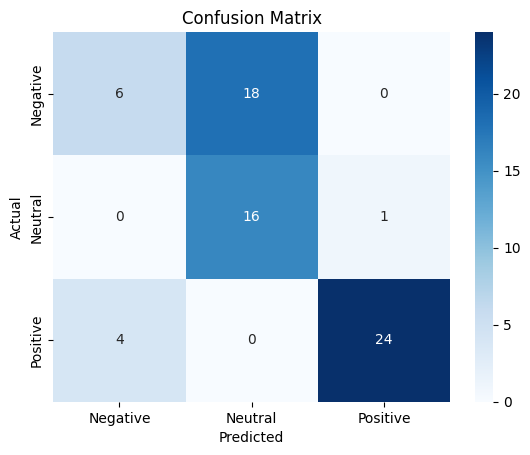

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

labels = sorted(testing_df['Sentiment_Text'].unique()) 

sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), 
            annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()